집단별 어떤 브랜드, 카테고리 제품의 푸시 알림을 보내는게 좋을까?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# "rfm.csv" 읽고 CustomerID 인덱스로 지정하기
df = pd.read_parquet('rfm.parquet.gzip')
df.shape

(18684, 9)

In [3]:
# Recency, Frequency, MonetaryValue 만 따로 rfm_cluster 변수에 담아 사용하기
rfm_cluster = df[['Recency', 'Frequency', 'MonetaryValue']]
print(rfm_cluster.shape)
rfm_cluster

(18684, 3)


,Recency,Frequency,MonetaryValue
user_id,,,
435648894,26,1,388.130005
437371552,30,1,179.139999
450756413,29,1,43.730000
456810531,7,1,133.350006
473668240,23,1,149.039993
...,...,...,...
566188229,1,1,221.339996
566210490,1,1,514.780029
566227458,1,1,465.910004


In [4]:
rfm_cluster.describe()

,Recency,Frequency,MonetaryValue
count,18684.000000,18684.000000,18684.000000
mean,15.103725,1.101263,409.069336
std,9.348765,0.431114,487.437958
min,1.000000,1.000000,2.450000
25%,7.000000,1.000000,131.529999
50%,13.000000,1.000000,243.470001
75%,24.000000,1.000000,506.282501
max,31.000000,12.000000,15507.000000


<Axes: xlabel='Recency', ylabel='count'>

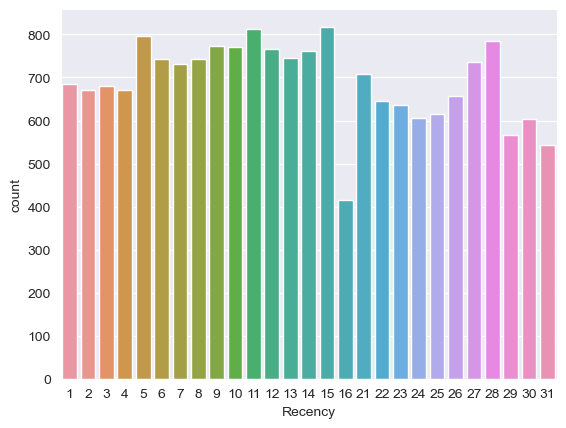

In [5]:
sns.countplot(data=df, x="Recency")

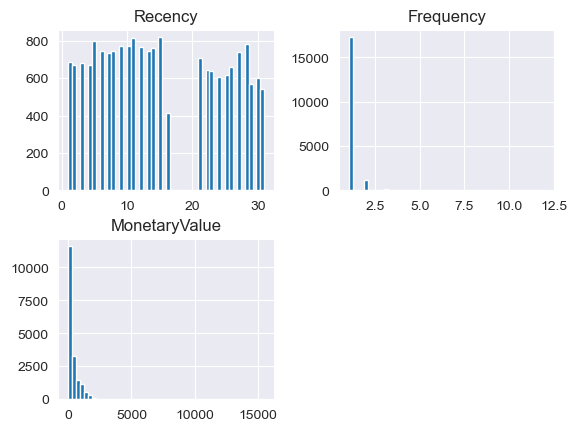

In [6]:
rfm_cluster.hist(bins=50);

In [7]:
# log 변환
# 회귀나 k-means에서 log 변환 시 성능이 조금 더 좋아짐

rfm_cluster_log = np.log(rfm_cluster + 1)
rfm_cluster_log.head()

,Recency,Frequency,MonetaryValue
user_id,,,
435648894,3.295837,0.693147,5.963913
437371552,3.433987,0.693147,5.193734
450756413,3.401197,0.693147,3.800644
456810531,2.079442,0.693147,4.900448
473668240,3.178054,0.693147,5.010902


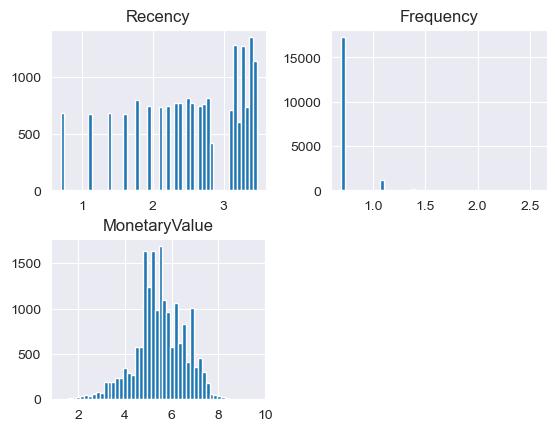

In [8]:
rfm_cluster_log.hist(bins=50);

In [9]:
rfm_cluster_log.describe()

,Recency,Frequency,MonetaryValue
count,18684.000000,18684.000000,18684.000000
mean,2.551565,0.730160,5.501298
std,0.745280,0.140117,1.062550
min,0.693147,0.693147,1.238374
25%,2.079442,0.693147,4.886809
50%,2.639057,0.693147,5.499093
75%,3.218876,0.693147,6.229068
max,3.465736,2.564949,9.649112


## 스케일링

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = StandardScaler()
X = scaler.fit_transform(rfm_cluster_log)
X

array([[ 0.99867391, -0.26416645,  0.43539276],
       [ 1.18404587, -0.26416645, -0.2894654 ],
       [ 1.14004805, -0.26416645, -1.60057897],
       ...,
       [-2.49364962, -0.26416645,  0.60689317],
       [-2.49364962, -0.26416645,  1.80187248],
       [-2.49364962, -0.26416645,  1.01645356]])

In [11]:
# 데이터 프레임으로 저장
pd.DataFrame(X).describe().round(2)

,0,1,2
count,18684.00,18684.00,18684.00
mean,-0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-2.49,-0.26,-4.01
25%,-0.63,-0.26,-0.58
50%,0.12,-0.26,-0.00
75%,0.90,-0.26,0.68
max,1.23,13.10,3.90


## KMeans

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

inertia = [] # 같은 애들끼리 얼마나 똘똘 뭉쳐있는지
silhouettes = []
range_n_clusters = range(2, 20)

for n_cluster in range_n_clusters:
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels=kmeans.labels_))
    print(n_cluster, end=',')

2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,

## Elbow Method

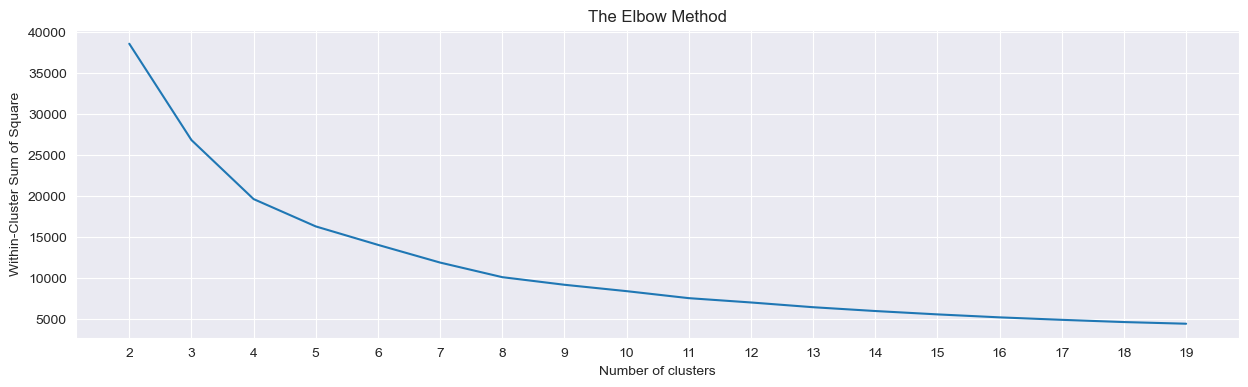

In [13]:
plt.figure(figsize=(15,4))
plt.plot(range_n_clusters, inertia)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Square')
plt.xticks(range_n_clusters)
plt.show()

## Silhouette Score

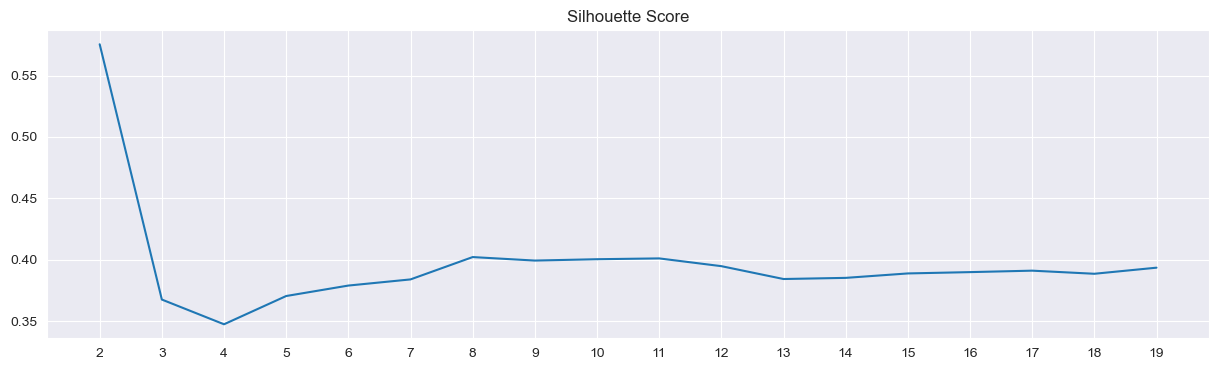

In [14]:
plt.figure(figsize=(15, 4))
plt.title('Silhouette Score')
plt.plot(range_n_clusters, silhouettes)
plt.xticks(range_n_clusters)
plt.show()

## KElbowVisualizer

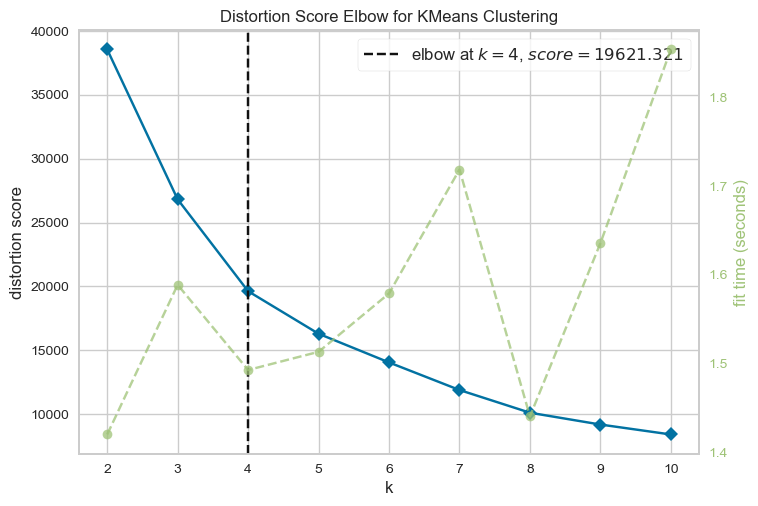

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
# yellowbrick.cluster 에서 KElbowVisualizer 불러오기
from yellowbrick.cluster import KElbowVisualizer

KEV = KElbowVisualizer(kmeans, k=10, n_init="auto")
KEV.fit(X)
KEV.show()

## 분석한 내용을 바탕으로 KMeans n_clusters 값을 정해 학습하기

In [94]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

In [95]:
kmeans.labels_

array([3, 1, 1, ..., 0, 0, 0])

In [96]:
pd.Series(kmeans.labels_).value_counts()

3    6356
1    6355
0    4571
2    1402
dtype: int64

In [19]:
# silhouette_score 구하기
silhouette_avg = silhouette_score(X, kmeans.labels_)
silhouette_avg

0.3474821060800943

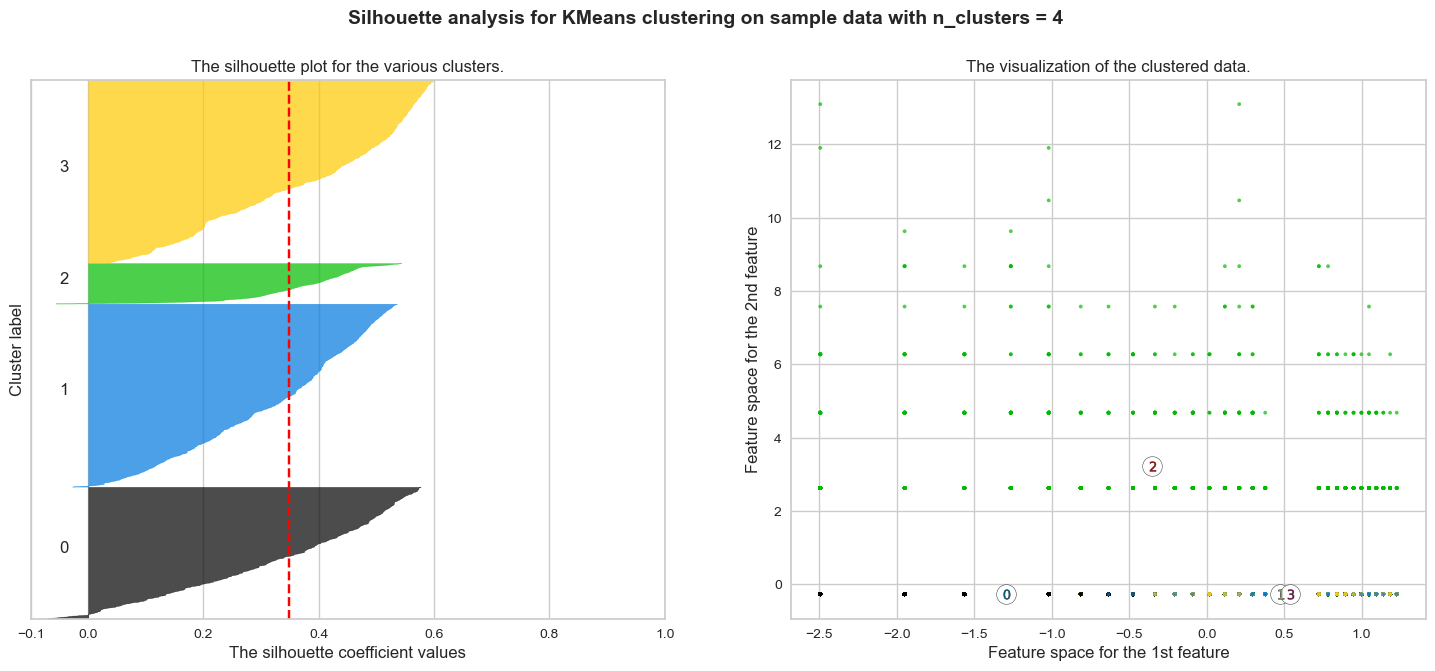

In [20]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
cluster_labels = kmeans.labels_
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()

In [ ]:
## 덴드로그램

In [21]:
df['Cluster'] = kmeans.labels_
df.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
435648894,26,1,388.130005,2,1,4,214,7,silver,3
437371552,30,1,179.139999,1,1,2,112,4,silver,1
450756413,29,1,43.730000,1,1,1,111,3,silver,1
456810531,7,1,133.350006,4,1,2,412,7,silver,0
473668240,23,1,149.039993,2,1,2,212,5,silver,1


In [22]:
# class를 qcut으로 구한거랑 머신러닝으로 구한 것 비교
pd.crosstab(df['RFM_class'], df['Cluster'])

Cluster,0,1,2,3
RFM_class,,,,
silver,649,5233,25,2459
gold,1363,958,108,2441
platinum,2559,164,1269,1456


### 보기만 많이 한 제품

In [23]:
# 전체 데이터프레임
total = pd.read_parquet('df.sample.parquet.gzip')
total.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id
6733995,2019-10-06 08:34:28+00:00,view,16700605,2053013559901684381,furniture.kitchen.chair,zeta,16.190001,518195082
4880941,2019-10-10 08:31:52+00:00,view,4800725,2053013554658804075,electronics.audio.headphone,sony,8.210000,512421337
6895456,2019-10-26 08:07:34+00:00,view,8800489,2053013555573162395,electronics.telephone,hiper,12.100000,518901124
807139,2019-10-07 06:33:45+00:00,cart,4201420,2053013552351936731,appliances.environment.air_conditioner,lg,787.630005,520085572
6297826,2019-10-25 18:07:49+00:00,view,1004739,2053013555631882655,electronics.smartphone,xiaomi,189.970001,513345774


In [24]:
total = total.drop('category_id', axis=1)
total.shape

(1000000, 7)

In [25]:
df_view = total[total['event_type'] == 'view']
df_view

,event_time,event_type,product_id,category_code,brand,price,user_id
6733995,2019-10-06 08:34:28+00:00,view,16700605,furniture.kitchen.chair,zeta,16.190001,518195082
4880941,2019-10-10 08:31:52+00:00,view,4800725,electronics.audio.headphone,sony,8.210000,512421337
6895456,2019-10-26 08:07:34+00:00,view,8800489,electronics.telephone,hiper,12.100000,518901124
6297826,2019-10-25 18:07:49+00:00,view,1004739,electronics.smartphone,xiaomi,189.970001,513345774
2679146,2019-10-03 06:44:48+00:00,view,2900200,appliances.kitchen.microwave,lg,85.790001,541666986
...,...,...,...,...,...,...,...
6869328,2019-10-06 10:23:48+00:00,view,4801033,electronics.audio.headphone,plantronics,12.720000,539951385
3558299,2019-10-09 08:26:06+00:00,view,1004209,electronics.smartphone,samsung,88.809998,558028016
1358710,2019-10-07 15:03:40+00:00,view,1005156,electronics.smartphone,xiaomi,308.630005,546202941
471300,2019-10-01 09:56:51+00:00,view,2701588,appliances.kitchen.refrigerators,samsung,552.320007,536280812


In [26]:
df_view.groupby(['product_id'])[['user_id']].count().sort_values(by='user_id', ascending=False)

,user_id
product_id,
1004856,15958
1004767,14536
1005115,12459
1004249,7786
1004833,7723
...,...
6301049,1
21408272,1
6300977,1


In [27]:
# product_id 구하기: 1004856, 1004767, 1005115, 1004249, 1004833번 product
idx = df_view.groupby(['product_id'])[['user_id']].count().sort_values(by='user_id', ascending=False).head().index
idx

Int64Index([1004856, 1004767, 1005115, 1004249, 1004833], dtype='int64', name='product_id')

In [28]:
idx = idx.to_list()

In [29]:
view_max = df_view[df_view['product_id'].isin(idx)][['category_code', 'brand', 'user_id','product_id']]
view_max

,category_code,brand,user_id,product_id
5479844,electronics.smartphone,samsung,527067848,1004856
5259709,electronics.smartphone,samsung,513638124,1004767
6412148,electronics.smartphone,apple,543473031,1004249
4052507,electronics.smartphone,apple,515356471,1005115
1810148,electronics.smartphone,samsung,545113746,1004856
...,...,...,...,...
365386,electronics.smartphone,apple,529808912,1005115
5408129,electronics.smartphone,samsung,545285462,1004833
5377549,electronics.smartphone,apple,535691166,1005115
5295319,electronics.smartphone,samsung,541711867,1004767


<Axes: >

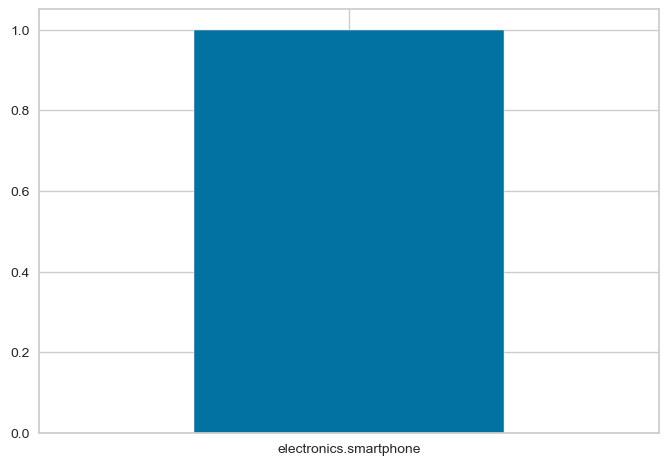

In [30]:
view_max['category_code'].value_counts(1).plot.bar(rot=0) # electronics.smartphone이 100퍼센트

<Axes: >

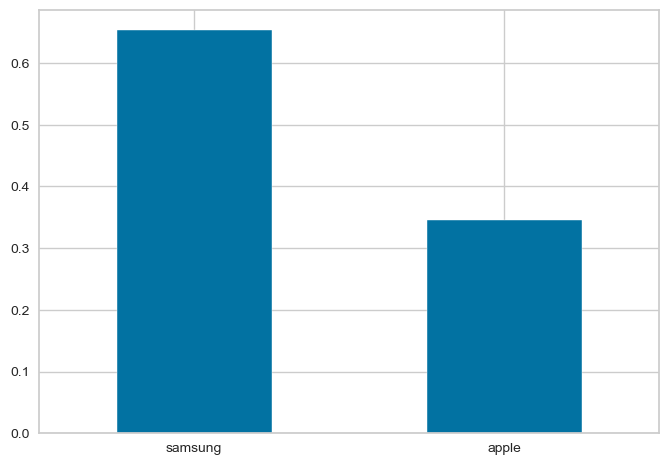

In [31]:
view_max['brand'].value_counts(1).plot.bar(rot=0) # smartphone 브랜드 samsumg, apple 순으로 높음

### 많이 본 제품 top5에 해당하는 user들이 구매는 안 했을까?

In [32]:
view_max['user_id'].nunique()

52381

In [33]:
user = view_max['user_id'].to_list()
user

[527067848,
 513638124,
 543473031,
 515356471,
 545113746,
 529045978,
 522217318,
 512419659,
 514101886,
 517391157,
 563186292,
 543316845,
 543427072,
 513843576,
 521484283,
 547874914,
 549368162,
 560728620,
 512796885,
 548909398,
 545355355,
 563355684,
 554675382,
 562662871,
 561970952,
 534623213,
 527060646,
 552464418,
 518546558,
 517950684,
 557469051,
 557748996,
 563293282,
 534379975,
 548192683,
 535884375,
 556751728,
 532006538,
 513067909,
 550780987,
 548856865,
 563988402,
 519071870,
 514767126,
 515149585,
 522841203,
 522977563,
 549776086,
 536138025,
 518612090,
 556256790,
 476197393,
 526929354,
 517593831,
 557511595,
 518752070,
 525259560,
 552110089,
 560673102,
 549135269,
 518891113,
 555144021,
 557070847,
 562933660,
 518327052,
 514451604,
 559090028,
 515842720,
 512844169,
 562178935,
 556664964,
 522840565,
 514810899,
 526210009,
 513296244,
 514897571,
 514444959,
 521938163,
 535890757,
 563421651,
 513367238,
 518572627,
 549377249,
 521

In [34]:
df_user = total[(total['user_id'].isin(user)) & (total['event_type'] == 'purchase') ]
df_user

,event_time,event_type,product_id,category_code,brand,price,user_id
4641753,2019-10-10 04:55:02+00:00,purchase,1003316,electronics.smartphone,apple,931.789978,526929354
1203259,2019-10-17 08:44:34+00:00,purchase,1004903,electronics.smartphone,huawei,111.699997,552848662
1718209,2019-10-17 15:20:59+00:00,purchase,1002974,electronics.smartphone,huawei,149.300003,512893581
2124196,2019-10-08 07:44:57+00:00,purchase,1004246,electronics.smartphone,apple,735.909973,513654377
3287475,2019-10-09 04:46:21+00:00,purchase,2900354,appliances.kitchen.microwave,horizont,70.349998,554620679
...,...,...,...,...,...,...,...
6078715,2019-10-31 06:39:53+00:00,purchase,1004856,electronics.smartphone,samsung,130.990005,565998174
5159105,2019-10-05 04:57:38+00:00,purchase,1004858,electronics.smartphone,samsung,132.559998,516072926
2651944,2019-10-28 10:33:04+00:00,purchase,1801690,electronics.video.tv,samsung,369.369995,512986964
1114357,2019-10-07 11:18:21+00:00,purchase,1004767,electronics.smartphone,samsung,251.410004,555890605


In [35]:
pd.merge(view_max, df_user, on=['product_id', 'user_id'], how='inner')['user_id'].nunique()

737

In [36]:
737 / 52381 * 100 # 1.4퍼센트의 user만 구매함

1.4069987209102537

### 장바구니에만 많이 담긴 제품

In [37]:
# 전체 데이터프레임
total = pd.read_parquet('df.sample.parquet.gzip')
total.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id
6733995,2019-10-06 08:34:28+00:00,view,16700605,2053013559901684381,furniture.kitchen.chair,zeta,16.190001,518195082
4880941,2019-10-10 08:31:52+00:00,view,4800725,2053013554658804075,electronics.audio.headphone,sony,8.210000,512421337
6895456,2019-10-26 08:07:34+00:00,view,8800489,2053013555573162395,electronics.telephone,hiper,12.100000,518901124
807139,2019-10-07 06:33:45+00:00,cart,4201420,2053013552351936731,appliances.environment.air_conditioner,lg,787.630005,520085572
6297826,2019-10-25 18:07:49+00:00,view,1004739,2053013555631882655,electronics.smartphone,xiaomi,189.970001,513345774


In [38]:
total = total.drop('category_id', axis=1)
total.shape

(1000000, 7)

In [39]:
df_cart = total[total['event_type'] == 'cart']
df_cart

,event_time,event_type,product_id,category_code,brand,price,user_id
807139,2019-10-07 06:33:45+00:00,cart,4201420,appliances.environment.air_conditioner,lg,787.630005,520085572
1710037,2019-10-27 15:24:05+00:00,cart,1004238,electronics.smartphone,apple,1243.790039,512894622
6403103,2019-10-25 19:52:30+00:00,cart,4804295,electronics.audio.headphone,xiaomi,22.860001,556806463
6742237,2019-10-06 08:41:09+00:00,cart,1002633,electronics.smartphone,apple,358.570007,546919618
3394398,2019-10-03 17:42:38+00:00,cart,1005109,electronics.smartphone,apple,975.570007,541931379
...,...,...,...,...,...,...,...
2442976,2019-10-08 11:55:10+00:00,cart,1004209,electronics.smartphone,samsung,88.809998,546221383
5308144,2019-10-20 05:19:18+00:00,cart,1004655,electronics.smartphone,samsung,787.280029,521070652
40002,2019-10-21 09:44:59+00:00,cart,3800985,appliances.iron,tefal,33.439999,559444423
1879071,2019-10-27 17:06:58+00:00,cart,8700327,appliances.personal.hair_cutter,philips,28.290001,538157414


In [40]:
df_cart.groupby(['product_id'])[['user_id']].count().sort_values(by='user_id', ascending=False)

,user_id
product_id,
1004856,1897
1004767,1378
4804056,806
1004833,777
1004870,674
...,...
3900968,1
3900895,1
3900839,1


In [41]:
# product_id 구하기
idx = df_cart.groupby(['product_id'])[['user_id']].count().sort_values(by='user_id', ascending=False).head().index
idx

Int64Index([1004856, 1004767, 4804056, 1004833, 1004870], dtype='int64', name='product_id')

In [42]:
idx = idx.to_list()

In [43]:
cart_max = df_view[df_view['product_id'].isin(idx)][['category_code', 'brand', 'user_id','product_id']]
cart_max

,category_code,brand,user_id,product_id
5479844,electronics.smartphone,samsung,527067848,1004856
6911629,electronics.audio.headphone,apple,562231435,4804056
5259709,electronics.smartphone,samsung,513638124,1004767
243255,electronics.smartphone,samsung,524038141,1004870
1810148,electronics.smartphone,samsung,545113746,1004856
...,...,...,...,...
1439346,electronics.smartphone,samsung,553828145,1004833
5573843,electronics.audio.headphone,apple,523185691,4804056
5408129,electronics.smartphone,samsung,545285462,1004833
5295319,electronics.smartphone,samsung,541711867,1004767


<Axes: >

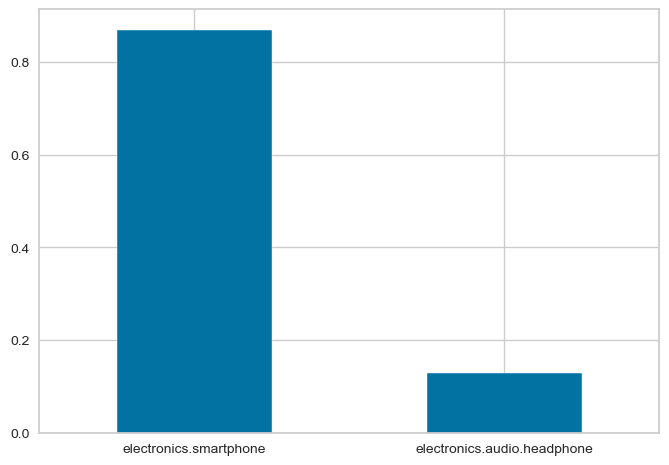

In [44]:
cart_max['category_code'].value_counts(1).plot.bar(rot=0) # smartphone, audio.headphone

<Axes: >

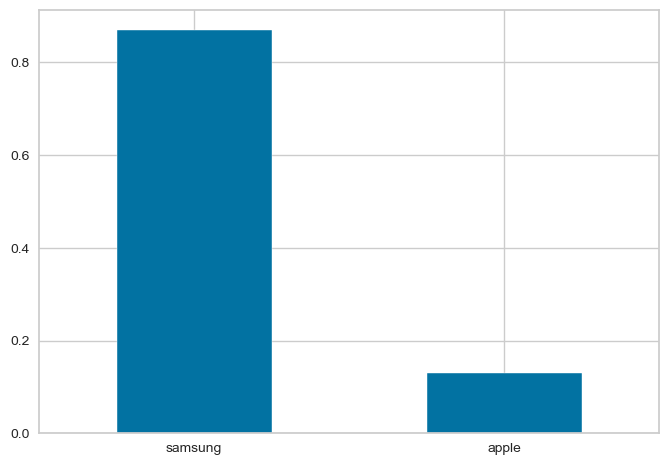

In [45]:
cart_max['brand'].value_counts(1).plot.bar(rot=0) # samsumg, apple 순으로 높음

In [46]:
total[total['category_code'] == 'electronics.audio.headphone']['brand'].unique()

array(['sony', 'apple', 'xiaomi', 'panasonic', 'huawei', 'jbl', 'ritmix',
       'samsung', 'hyperx', 'marshall', 'bose', 'acme', 'hp',
       'steelseries', 'defender', 'plantronics', 'elari', 'inkax',
       'harper', 'usams', 'awei', 'olto', 'cowon', 'kingston', 'koss',
       'razer', 'meizu', 'sven', 'audio-technica', 'monster', 'olmio',
       'jabra', 'lenovo', 'logitech', 'sennheiser', 'shure', 'manhattan',
       'beats', 'beyerdynamic', 'hoco', 'ergo', 'behringer', 'redragon',
       'veho', 'denn', 'pioneer', 'trust', 'g-cube', 'asus', 'remax',
       'yamaha', 'westone', 'marley', 'microlab', 'canyon', 'global',
       'gamemax', 'rapoo', 'philips', 'orico', 'bluedio', 'parrot', 'cnd',
       'wuw', 'nokia', 'akg', 'honor', 'joyroom', 'crown', 'acqua',
       'delux', 'genius', 'dunu', 'fiio', 'ipipoo', 'edifier', 'rombica',
       'zalman', 'lg', 'alesis', 'magnat', 'gigabyte', 'creative',
       'havit', 'soundking', 'fender', 'acer', 'roland', 'hercules',
       'intro',

### 장바구니에 많이 담은 제품 top5에 해당하는 user들이 구매는 안 했을까?

In [47]:
cart_max['user_id'].nunique()

46421

In [48]:
user = cart_max['user_id'].to_list()
user

[527067848,
 562231435,
 513638124,
 524038141,
 545113746,
 529045978,
 522217318,
 516275943,
 512419659,
 514263505,
 517391157,
 563186292,
 543316845,
 543427072,
 513843576,
 547874914,
 519438409,
 549368162,
 560728620,
 512796885,
 527984906,
 554675382,
 530188395,
 562662871,
 541852247,
 561970952,
 534623213,
 527060646,
 518546558,
 557469051,
 555719852,
 557748996,
 563293282,
 556128368,
 554014588,
 514743865,
 548192683,
 535884375,
 556751728,
 532006538,
 513067909,
 548856865,
 517507932,
 563988402,
 534177766,
 565643146,
 522841203,
 564002935,
 536138025,
 526234882,
 518612090,
 520045730,
 556256790,
 517593831,
 512452970,
 513184431,
 518752070,
 525259560,
 552110089,
 516537168,
 557070847,
 513658170,
 562933660,
 545096197,
 515172497,
 518327052,
 515842475,
 543846883,
 517743323,
 512852133,
 522840565,
 514810899,
 526210009,
 513296244,
 521938163,
 535236121,
 535890757,
 563421651,
 513367238,
 549377249,
 513271961,
 521730835,
 564387060,
 556

In [49]:
df_user = total[(total['user_id'].isin(user)) & (total['event_type'] == 'purchase') ]
df_user

,event_time,event_type,product_id,category_code,brand,price,user_id
1203259,2019-10-17 08:44:34+00:00,purchase,1004903,electronics.smartphone,huawei,111.699997,552848662
1718209,2019-10-17 15:20:59+00:00,purchase,1002974,electronics.smartphone,huawei,149.300003,512893581
3287475,2019-10-09 04:46:21+00:00,purchase,2900354,appliances.kitchen.microwave,horizont,70.349998,554620679
1456452,2019-10-07 16:08:08+00:00,purchase,4804056,electronics.audio.headphone,apple,160.360001,512688687
4481827,2019-10-10 00:53:31+00:00,purchase,1004739,electronics.smartphone,xiaomi,189.940002,536825582
...,...,...,...,...,...,...,...
6078715,2019-10-31 06:39:53+00:00,purchase,1004856,electronics.smartphone,samsung,130.990005,565998174
5549853,2019-10-25 09:23:11+00:00,purchase,4804056,electronics.audio.headphone,apple,159.910004,515170148
5159105,2019-10-05 04:57:38+00:00,purchase,1004858,electronics.smartphone,samsung,132.559998,516072926
1114357,2019-10-07 11:18:21+00:00,purchase,1004767,electronics.smartphone,samsung,251.410004,555890605


In [50]:
pd.merge(view_max, df_user, on=['product_id', 'user_id'], how='inner')['user_id'].nunique()

542

In [84]:
542 / 46421 * 100

1.1675750199263264

### 집단별 많이 구매한 브랜드 or 카테고리
#### 0번 집단

In [52]:
clu0 = df[df['Cluster'] == 0]
clu0

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
456810531,7,1,133.350006,4,1,2,412,7,silver,0
480434060,4,1,293.190002,5,1,4,514,10,gold,0
502104092,4,1,164.979996,5,1,2,512,8,silver,0
512364767,3,1,23.090000,5,1,1,511,7,silver,0
512365272,2,1,40.880001,5,1,1,511,7,silver,0
...,...,...,...,...,...,...,...,...,...,...
566188229,1,1,221.339996,5,5,3,553,13,platinum,0
566210490,1,1,514.780029,5,5,4,554,14,platinum,0
566227458,1,1,465.910004,5,5,4,554,14,platinum,0


<Axes: >

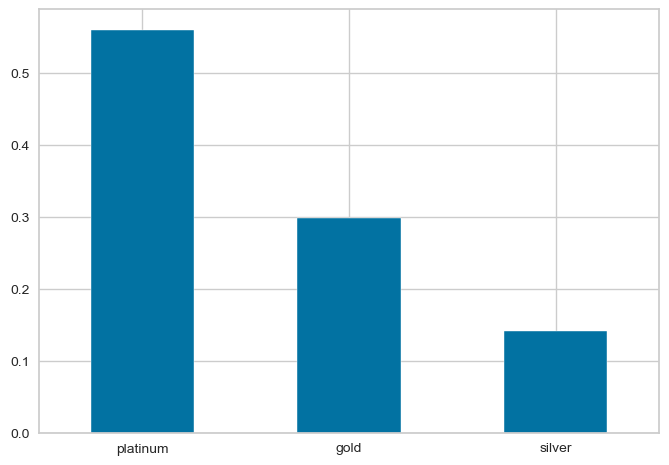

In [53]:
clu0['RFM_class'].value_counts(1).plot.bar(rot=0) # 0번 클러스터에는 platinum 고객이 많음

In [54]:
clu0 = clu0.reset_index()
clu0

,user_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
0,456810531,7,1,133.350006,4,1,2,412,7,silver,0
1,480434060,4,1,293.190002,5,1,4,514,10,gold,0
2,502104092,4,1,164.979996,5,1,2,512,8,silver,0
3,512364767,3,1,23.090000,5,1,1,511,7,silver,0
4,512365272,2,1,40.880001,5,1,1,511,7,silver,0
...,...,...,...,...,...,...,...,...,...,...,...
4566,566188229,1,1,221.339996,5,5,3,553,13,platinum,0
4567,566210490,1,1,514.780029,5,5,4,554,14,platinum,0
4568,566227458,1,1,465.910004,5,5,4,554,14,platinum,0
4569,566246516,1,1,1661.089966,5,5,5,555,15,platinum,0


In [55]:
idx0 = clu0['user_id'].to_list()
idx0

[456810531,
 480434060,
 502104092,
 512364767,
 512365272,
 512366378,
 512371970,
 512375076,
 512380514,
 512387840,
 512388596,
 512391370,
 512391883,
 512394753,
 512397411,
 512398611,
 512400833,
 512406376,
 512412345,
 512413306,
 512416579,
 512417206,
 512418634,
 512419426,
 512424173,
 512426765,
 512427417,
 512430073,
 512432406,
 512433516,
 512436336,
 512436344,
 512437594,
 512442232,
 512446617,
 512446922,
 512450593,
 512452414,
 512452626,
 512452645,
 512459353,
 512460204,
 512462542,
 512463048,
 512463951,
 512466047,
 512466552,
 512467267,
 512469838,
 512469937,
 512471052,
 512472650,
 512472766,
 512476454,
 512479868,
 512485976,
 512486458,
 512487196,
 512495159,
 512495214,
 512500808,
 512502450,
 512506407,
 512506589,
 512510040,
 512511109,
 512512039,
 512512703,
 512517779,
 512518354,
 512521427,
 512524826,
 512526460,
 512527768,
 512528795,
 512531824,
 512537329,
 512538316,
 512546149,
 512551009,
 512551478,
 512556904,
 512557746,
 512

In [56]:
df_user0 = total[(total['event_type'] == 'purchase') & (total['user_id'].isin(idx0))]
df_user0

,event_time,event_type,product_id,category_code,brand,price,user_id
5792020,2019-10-30 20:34:36+00:00,purchase,1307074,computers.notebook,acer,743.750000,530225520
3681972,2019-10-29 07:08:18+00:00,purchase,1801905,electronics.video.tv,samsung,1029.369995,549094958
3933905,2019-10-29 11:04:20+00:00,purchase,5801483,electronics.audio.subwoofer,pioneer,58.939999,562983662
4758173,2019-10-30 04:40:53+00:00,purchase,1004247,electronics.smartphone,apple,786.109985,546840963
5930359,2019-10-25 14:13:12+00:00,purchase,1004767,electronics.smartphone,samsung,245.500000,514323634
...,...,...,...,...,...,...,...
4743812,2019-10-30 04:25:10+00:00,purchase,1004767,electronics.smartphone,samsung,243.220001,514677648
2651944,2019-10-28 10:33:04+00:00,purchase,1801690,electronics.video.tv,samsung,369.369995,512986964
1092912,2019-10-27 07:26:40+00:00,purchase,1004659,electronics.smartphone,samsung,720.690002,564606287
5885576,2019-10-31 03:09:33+00:00,purchase,1005151,electronics.smartphone,xiaomi,405.950012,539921763


<Axes: >

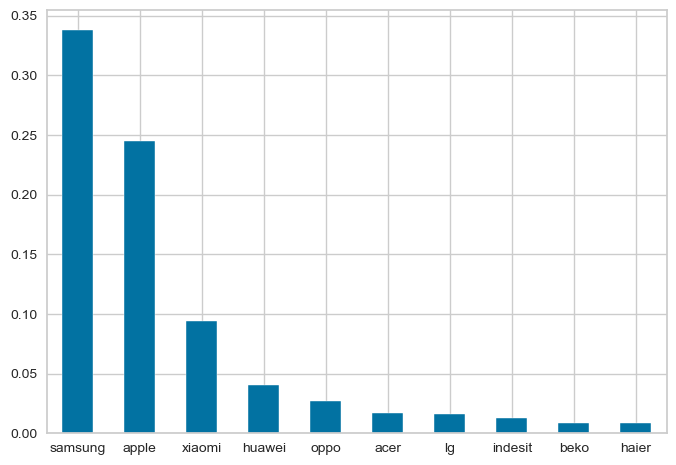

In [57]:
df_user0['brand'].value_counts(1).head(10).plot.bar(rot=0)

<Axes: >

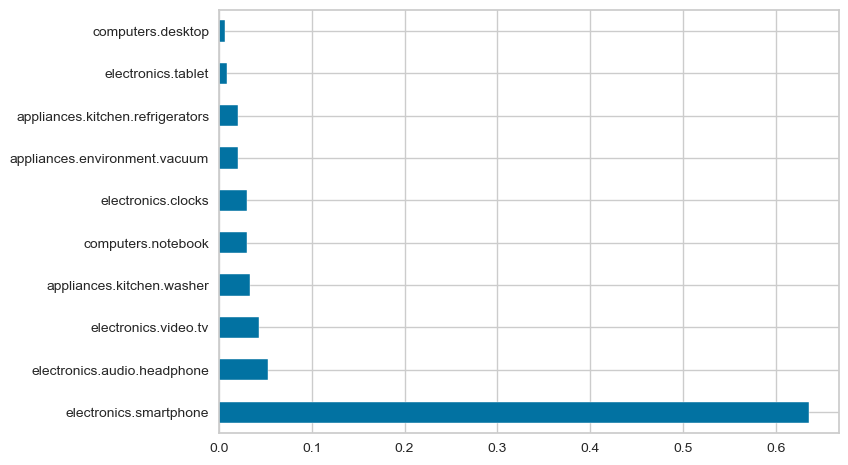

In [58]:
df_user0['category_code'].value_counts(1).head(10).plot.barh(rot=0)

#### 1번 집단

In [59]:
clu1 = df[df['Cluster'] == 1]
clu1

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
437371552,30,1,179.139999,1,1,2,112,4,silver,1
450756413,29,1,43.730000,1,1,1,111,3,silver,1
473668240,23,1,149.039993,2,1,2,212,5,silver,1
494841527,14,1,190.220001,3,1,3,313,7,silver,1
496157842,11,1,52.000000,4,1,1,411,6,silver,1
...,...,...,...,...,...,...,...,...,...,...
564585817,5,1,36.009998,5,5,1,551,11,platinum,1
564627134,5,1,8.370000,5,5,1,551,11,platinum,1
564669296,5,1,30.280001,5,5,1,551,11,platinum,1


<Axes: >

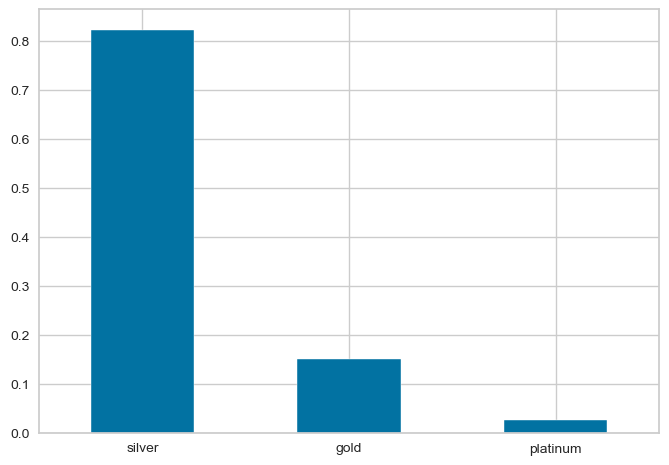

In [60]:
clu1['RFM_class'].value_counts(1).plot.bar(rot=0) # 0번 클러스터에는 sliver 고객이 많음

In [61]:
clu1 = clu1.reset_index()
clu1

,user_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
0,437371552,30,1,179.139999,1,1,2,112,4,silver,1
1,450756413,29,1,43.730000,1,1,1,111,3,silver,1
2,473668240,23,1,149.039993,2,1,2,212,5,silver,1
3,494841527,14,1,190.220001,3,1,3,313,7,silver,1
4,496157842,11,1,52.000000,4,1,1,411,6,silver,1
...,...,...,...,...,...,...,...,...,...,...,...
6350,564585817,5,1,36.009998,5,5,1,551,11,platinum,1
6351,564627134,5,1,8.370000,5,5,1,551,11,platinum,1
6352,564669296,5,1,30.280001,5,5,1,551,11,platinum,1
6353,564702419,5,1,41.439999,5,5,1,551,11,platinum,1


In [62]:
idx1 = clu1['user_id'].to_list()
idx1

[437371552,
 450756413,
 473668240,
 494841527,
 496157842,
 497552274,
 500246310,
 504064036,
 512363812,
 512364788,
 512365686,
 512365864,
 512366827,
 512367004,
 512367876,
 512369920,
 512370388,
 512371009,
 512373004,
 512373523,
 512373717,
 512374312,
 512375169,
 512377570,
 512377624,
 512378389,
 512379299,
 512379753,
 512379859,
 512381347,
 512381373,
 512382386,
 512382995,
 512383304,
 512384661,
 512384831,
 512390127,
 512390296,
 512391098,
 512393380,
 512393542,
 512394153,
 512394754,
 512394917,
 512396559,
 512396845,
 512397764,
 512397916,
 512401643,
 512402370,
 512405369,
 512405509,
 512406373,
 512407984,
 512409674,
 512410719,
 512412385,
 512413933,
 512415625,
 512415703,
 512418890,
 512420294,
 512420345,
 512421583,
 512422429,
 512426430,
 512428527,
 512429031,
 512429516,
 512430793,
 512430889,
 512430908,
 512432515,
 512432519,
 512435113,
 512436144,
 512438173,
 512438370,
 512442194,
 512442280,
 512442625,
 512444155,
 512452391,
 512

In [63]:
df_user1 = total[(total['event_type'] == 'purchase') & (total['user_id'].isin(idx1))]
df_user1

,event_time,event_type,product_id,category_code,brand,price,user_id
3426987,2019-10-23 16:38:27+00:00,purchase,1005204,electronics.smartphone,xiaomi,156.470001,512564650
1718209,2019-10-17 15:20:59+00:00,purchase,1002974,electronics.smartphone,huawei,149.300003,512893581
2372897,2019-10-08 10:56:45+00:00,purchase,3700689,appliances.environment.vacuum,samsung,181.449997,541225443
1199425,2019-10-17 08:41:53+00:00,purchase,1004750,electronics.smartphone,samsung,196.600006,513199553
1227351,2019-10-22 06:44:49+00:00,purchase,6000094,auto.accessories.alarm,starline,121.239998,515346543
...,...,...,...,...,...,...,...
6724882,2019-10-21 04:02:31+00:00,purchase,6000227,auto.accessories.alarm,starline,157.529999,560132689
4129386,2019-10-19 08:59:35+00:00,purchase,1004748,electronics.smartphone,huawei,126.889999,514818734
5700677,2019-10-05 12:36:21+00:00,purchase,1004143,electronics.smartphone,xiaomi,141.320007,543460371
6725651,2019-10-21 04:03:20+00:00,purchase,5000065,appliances.sewing_machine,janome,209.259995,540473225


<Axes: >

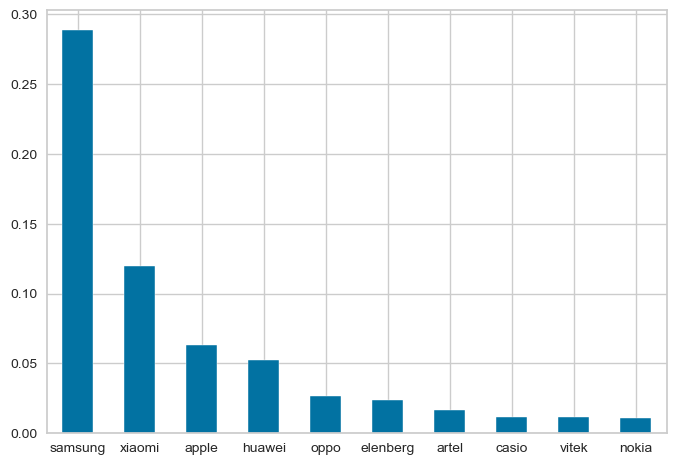

In [64]:
df_user1['brand'].value_counts(1).head(10).plot.bar(rot=0)

<Axes: >

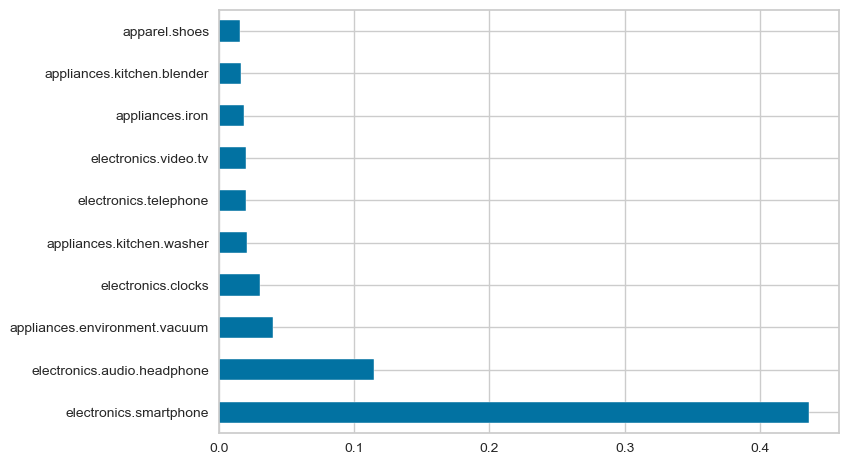

In [65]:
df_user1['category_code'].value_counts(1).head(10).plot.barh(rot=0)

#### 2번 집단

In [66]:
clu2 = df[df['Cluster'] == 2]
clu2

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
497226076,2,2,2187.750000,5,5,5,555,15,platinum,2
512373343,11,2,276.640015,4,5,3,453,12,platinum,2
512382879,10,3,514.890015,4,5,4,454,13,platinum,2
512384696,26,2,1276.739990,2,5,5,255,12,platinum,2
512386086,2,6,3787.049805,5,5,5,555,15,platinum,2
...,...,...,...,...,...,...,...,...,...,...
565431133,1,2,254.779999,5,5,3,553,13,platinum,2
565600224,1,2,87.000000,5,5,1,551,11,platinum,2
565667660,2,2,819.549988,5,5,5,555,15,platinum,2


<Axes: >

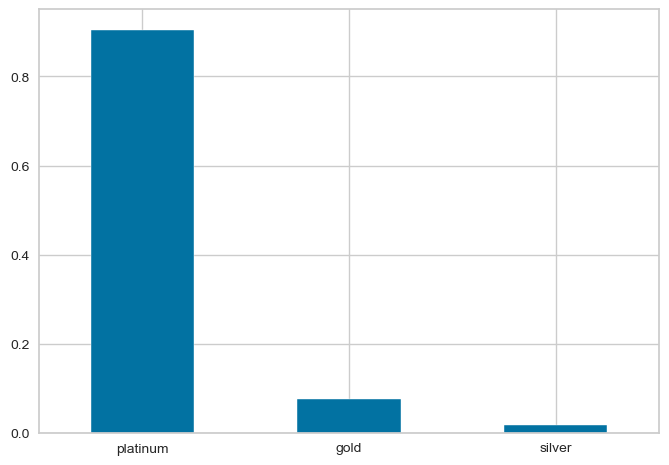

In [67]:
clu2['RFM_class'].value_counts(1).plot.bar(rot=0) # 2번 클러스터에는 platinum 고객이 많음

In [68]:
clu2 = clu2.reset_index()
clu2

,user_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
0,497226076,2,2,2187.750000,5,5,5,555,15,platinum,2
1,512373343,11,2,276.640015,4,5,3,453,12,platinum,2
2,512382879,10,3,514.890015,4,5,4,454,13,platinum,2
3,512384696,26,2,1276.739990,2,5,5,255,12,platinum,2
4,512386086,2,6,3787.049805,5,5,5,555,15,platinum,2
...,...,...,...,...,...,...,...,...,...,...,...
1397,565431133,1,2,254.779999,5,5,3,553,13,platinum,2
1398,565600224,1,2,87.000000,5,5,1,551,11,platinum,2
1399,565667660,2,2,819.549988,5,5,5,555,15,platinum,2
1400,565724616,2,2,337.220001,5,5,4,554,14,platinum,2


In [69]:
idx2 = clu2['user_id'].to_list()
idx2

[497226076,
 512373343,
 512382879,
 512384696,
 512386086,
 512387881,
 512409624,
 512411061,
 512416095,
 512419726,
 512420304,
 512421126,
 512424209,
 512425205,
 512432509,
 512437914,
 512445529,
 512454459,
 512461752,
 512465881,
 512466913,
 512470884,
 512476567,
 512486927,
 512487065,
 512487885,
 512493135,
 512502799,
 512511358,
 512514956,
 512524843,
 512525276,
 512527352,
 512539881,
 512569455,
 512571278,
 512572497,
 512577810,
 512589613,
 512597782,
 512600500,
 512615330,
 512640910,
 512654599,
 512654674,
 512657067,
 512678019,
 512681805,
 512685837,
 512694680,
 512699299,
 512703327,
 512704796,
 512714138,
 512716665,
 512721703,
 512730977,
 512734912,
 512735874,
 512736046,
 512739664,
 512740625,
 512745478,
 512748362,
 512750674,
 512752956,
 512757284,
 512759725,
 512762688,
 512764487,
 512781472,
 512787830,
 512788044,
 512793126,
 512801161,
 512803922,
 512821043,
 512825823,
 512839423,
 512869184,
 512870255,
 512871246,
 512875998,
 512

In [70]:
df_user2 = total[(total['event_type'] == 'purchase') & (total['user_id'].isin(idx2))]
df_user2

,event_time,event_type,product_id,category_code,brand,price,user_id
4641753,2019-10-10 04:55:02+00:00,purchase,1003316,electronics.smartphone,apple,931.789978,526929354
1203259,2019-10-17 08:44:34+00:00,purchase,1004903,electronics.smartphone,huawei,111.699997,552848662
4243318,2019-10-24 10:09:11+00:00,purchase,1004209,electronics.smartphone,samsung,88.790001,527998584
6947571,2019-10-26 08:45:34+00:00,purchase,1005100,electronics.smartphone,samsung,140.699997,513006995
2124196,2019-10-08 07:44:57+00:00,purchase,1004246,electronics.smartphone,apple,735.909973,513654377
...,...,...,...,...,...,...,...
6720277,2019-10-26 05:55:32+00:00,purchase,1002629,electronics.smartphone,apple,358.250000,512949418
3362905,2019-10-09 05:50:33+00:00,purchase,4500032,appliances.kitchen.hob,bosch,233.880005,523072676
3555353,2019-10-18 19:39:00+00:00,purchase,1005118,electronics.smartphone,apple,1003.630005,550514115
3791839,2019-10-09 11:33:39+00:00,purchase,1004209,electronics.smartphone,samsung,88.809998,554410859


<Axes: >

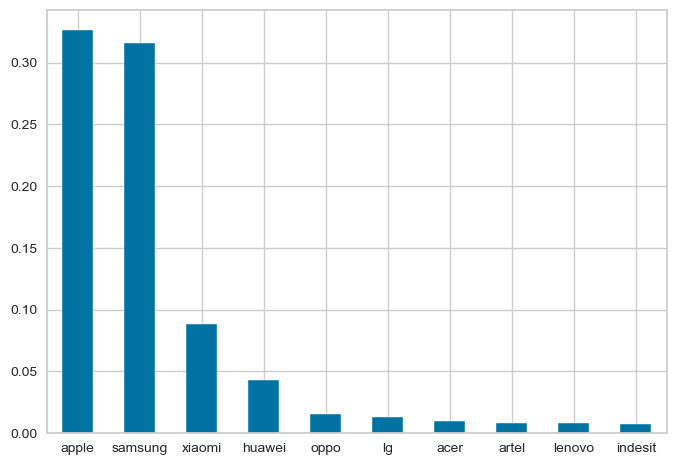

In [71]:
df_user2['brand'].value_counts(1).head(10).plot.bar(rot=0)

<Axes: >

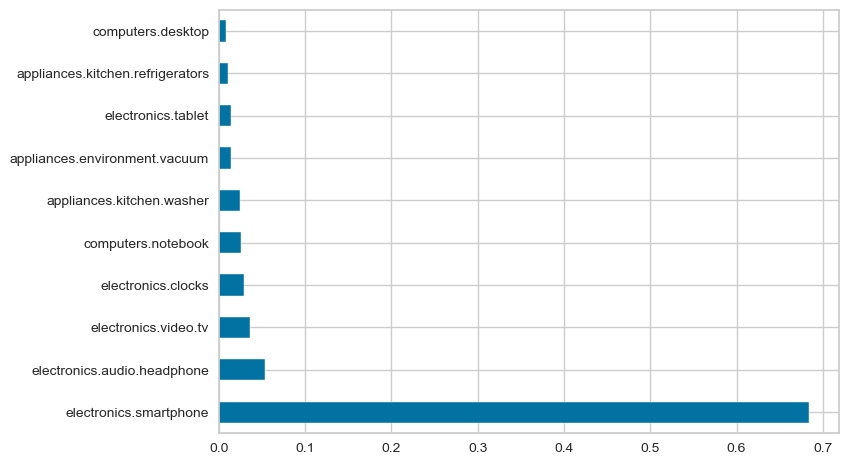

In [72]:
df_user2['category_code'].value_counts(1).head(10).plot.barh(rot=0)

#### 3번 집단

In [73]:
clu3 = df[df['Cluster'] == 3]
clu3

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
user_id,,,,,,,,,,
435648894,26,1,388.130005,2,1,4,214,7,silver,3
477652311,25,1,250.970001,2,1,3,213,6,silver,3
490607253,27,1,993.330017,1,1,5,115,7,silver,3
512365112,26,1,286.600006,2,1,3,213,6,silver,3
512366424,14,1,272.589996,3,1,3,313,7,silver,3
...,...,...,...,...,...,...,...,...,...,...
564264267,6,1,1375.819946,4,5,5,455,14,platinum,3
564430801,6,1,1372.599976,4,5,5,455,14,platinum,3
564438856,6,1,1702.739990,4,5,5,455,14,platinum,3


<Axes: >

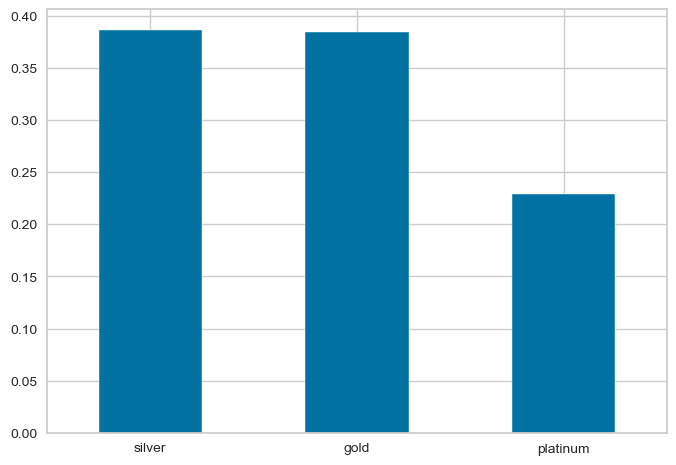

In [74]:
clu3['RFM_class'].value_counts(1).plot.bar(rot=0) # 3번 클러스터에는 sliver & gold 고객이 많음 

In [75]:
clu3 = clu3.reset_index()
clu3

,user_id,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class,Cluster
0,435648894,26,1,388.130005,2,1,4,214,7,silver,3
1,477652311,25,1,250.970001,2,1,3,213,6,silver,3
2,490607253,27,1,993.330017,1,1,5,115,7,silver,3
3,512365112,26,1,286.600006,2,1,3,213,6,silver,3
4,512366424,14,1,272.589996,3,1,3,313,7,silver,3
...,...,...,...,...,...,...,...,...,...,...,...
6351,564264267,6,1,1375.819946,4,5,5,455,14,platinum,3
6352,564430801,6,1,1372.599976,4,5,5,455,14,platinum,3
6353,564438856,6,1,1702.739990,4,5,5,455,14,platinum,3
6354,564460153,6,1,1481.560059,4,5,5,455,14,platinum,3


In [76]:
idx3 = clu3['user_id'].to_list()
idx3

[435648894,
 477652311,
 490607253,
 512365112,
 512366424,
 512366670,
 512368363,
 512368578,
 512369991,
 512371395,
 512372215,
 512372673,
 512372698,
 512372774,
 512374044,
 512374443,
 512375027,
 512375245,
 512375395,
 512376205,
 512378682,
 512380408,
 512381328,
 512382536,
 512385152,
 512387329,
 512388376,
 512390241,
 512392050,
 512397594,
 512397595,
 512399120,
 512399810,
 512400749,
 512401354,
 512402604,
 512402640,
 512402926,
 512402999,
 512403401,
 512406792,
 512408264,
 512410265,
 512412945,
 512414339,
 512416355,
 512417147,
 512419229,
 512420142,
 512423867,
 512425127,
 512425192,
 512426820,
 512427380,
 512433589,
 512434089,
 512434868,
 512434925,
 512434953,
 512435896,
 512438845,
 512440638,
 512441123,
 512444935,
 512445719,
 512446257,
 512447001,
 512447778,
 512449423,
 512449463,
 512450044,
 512450101,
 512456092,
 512457495,
 512458120,
 512458534,
 512460864,
 512461119,
 512461237,
 512462656,
 512470588,
 512471569,
 512471975,
 512

In [77]:
df_user3 = total[(total['event_type'] == 'purchase') & (total['user_id'].isin(idx3))]
df_user3

,event_time,event_type,product_id,category_code,brand,price,user_id
3995206,2019-10-09 14:25:09+00:00,purchase,1005118,electronics.smartphone,apple,1015.200012,512736880
2321640,2019-10-22 21:51:18+00:00,purchase,1002544,electronics.smartphone,apple,458.700012,516355074
1247291,2019-10-02 00:21:42+00:00,purchase,1003317,electronics.smartphone,apple,939.539978,534847390
2748040,2019-10-23 08:13:02+00:00,purchase,1005105,electronics.smartphone,apple,1399.010010,531565100
822606,2019-10-01 15:06:16+00:00,purchase,1801581,electronics.video.tv,yasin,374.500000,517041134
...,...,...,...,...,...,...,...
3334661,2019-10-09 05:27:08+00:00,purchase,1005124,electronics.smartphone,apple,1671.859985,525780151
5657329,2019-10-10 19:00:08+00:00,purchase,1002528,electronics.smartphone,apple,591.750000,549979935
4296173,2019-10-04 12:15:19+00:00,purchase,1307071,computers.notebook,acer,643.260010,512650236
982552,2019-10-17 05:54:59+00:00,purchase,1004250,electronics.smartphone,apple,798.229980,541860636


<Axes: >

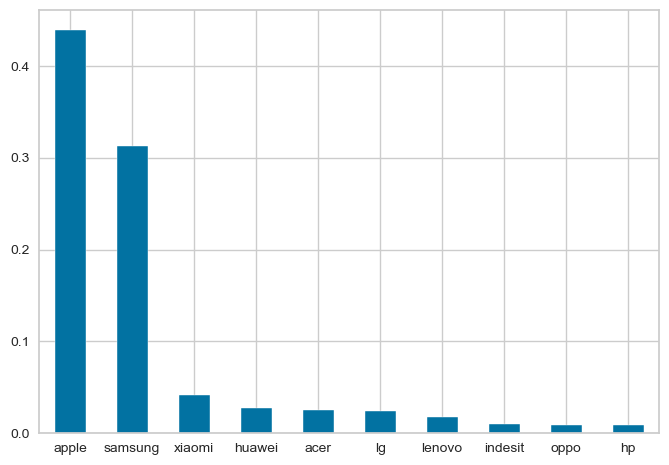

In [78]:
df_user3['brand'].value_counts(1).head(10).plot.bar(rot=0)

<Axes: >

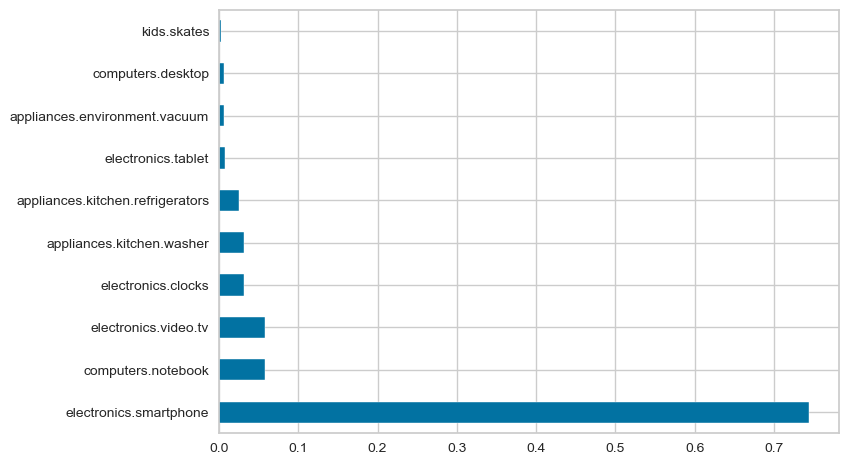

In [79]:
df_user3['category_code'].value_counts(1).head(10).plot.barh(rot=0)

### 집단별 고객 클래스 비교

In [80]:
clu0['RFM_class'].value_counts(1) # 0번 클러스터에는 platinum 고객이 많음 

platinum    0.559834
gold        0.298184
silver      0.141982
Name: RFM_class, dtype: float64

In [81]:
clu1['RFM_class'].value_counts(1) # 1번 클러스터에는 sliver 고객이 많음 

silver      0.823446
gold        0.150747
platinum    0.025806
Name: RFM_class, dtype: float64

In [82]:
clu2['RFM_class'].value_counts(1) # 2번 클러스터에는 platinum 고객이 많음 

platinum    0.905136
gold        0.077033
silver      0.017832
Name: RFM_class, dtype: float64

In [83]:
clu3['RFM_class'].value_counts(1) # 3번 클러스터에는 sliver & gold 고객이 많음

silver      0.386879
gold        0.384047
platinum    0.229075
Name: RFM_class, dtype: float64

## 카테고리별 집단 고객 수 비교

## 브랜드별 집단 고객 수 비교